In [1]:
import sys
import numpy as np
import torch
from hessian_eigenthings import compute_hessian_eigenthings

import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

In [2]:
sys.path.append("../../src")
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification, SquaredClassification
from block_analysis import *
from derivation import get_hessian_grad_block, block_norm, infer_layer_idx

## Params

In [3]:
# Model
mode = "linear"
bias = False
nlayer = 2
inp_dim = 10 
out_dim = 10
hid_dim = 1000

# Data parameters
nsamp = 5000
inp_mean = 1
inp_var = 1

# Others
device = 0
lr = 1
Neigen = 50

In [4]:
from torchessian.plotting import plot_leading_eigen
from torchessian import batch_hessian_eigen
from derivation  import analytic_hessian_eigen

# Summary

WIP - todo:

## 1. Linear Loss
#### 1.1 Linear 0 mean

Investigate for different depth and width

### 1.2 Linear non-0 mean
### 1.3 ReLU

## 1. Squared Loss
### 1.1 Linear 0 mean
### 1.2 Linear non-0 mean
### 1.3 ReLU


In [5]:
hid_dims = [10,100,1000]

### 2 layers

In [6]:
nlayer = 2
mode = "linear"

In [7]:
ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
               out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)

  0%|          | 0/49 [00:00<?, ?it/s]

[Complete LANCZOS Algorithm running]


 43%|████▎     | 21/49 [00:00<00:00, 198.82it/s]

[Complete LANCZOS Algorithm running]


 43%|████▎     | 21/49 [00:00<00:00, 205.97it/s]

[Complete LANCZOS Algorithm running]


100%|██████████| 49/49 [00:00<00:00, 129.07it/s]


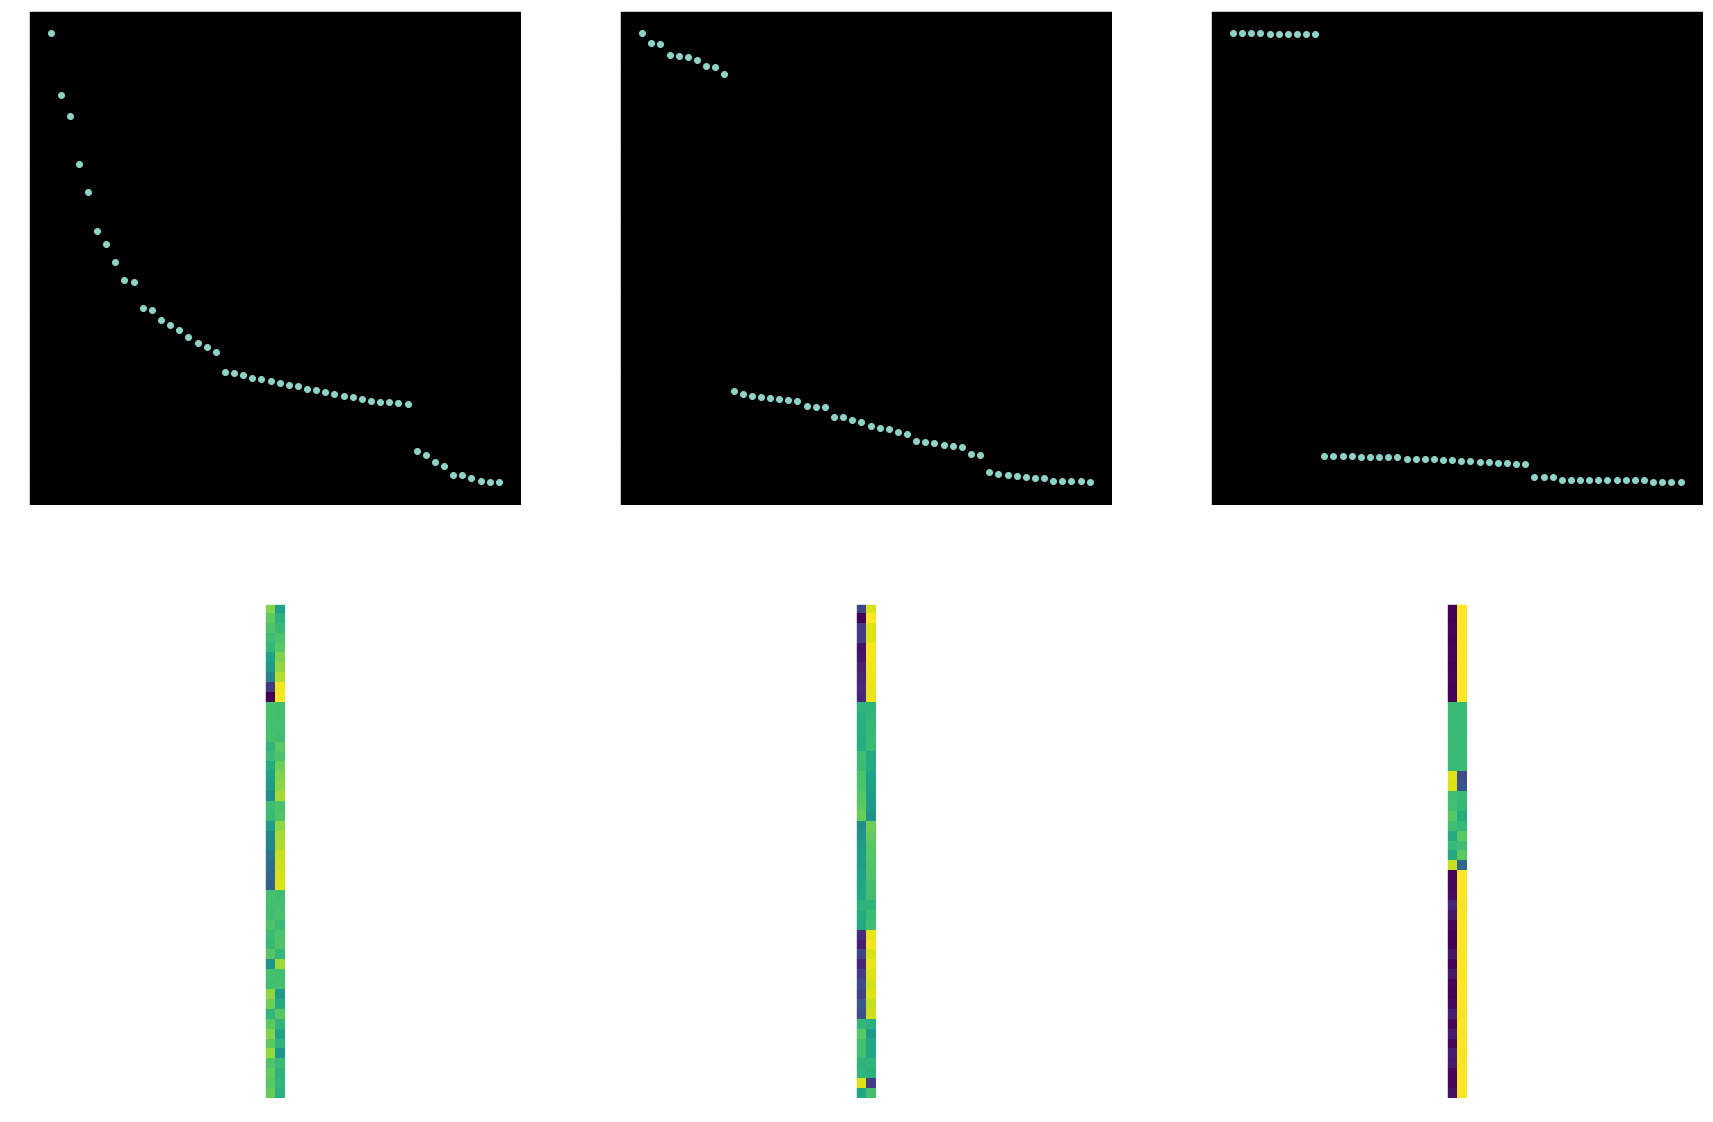

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for i,hid_dim in enumerate(hid_dims):
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    eigenval, eigenvec = batch_hessian_eigen(model, ds, loss_fn, Neigen)
    plot_leading_eigen(eigenval, eigenvec, model, Neigen, ax=ax[:,i])

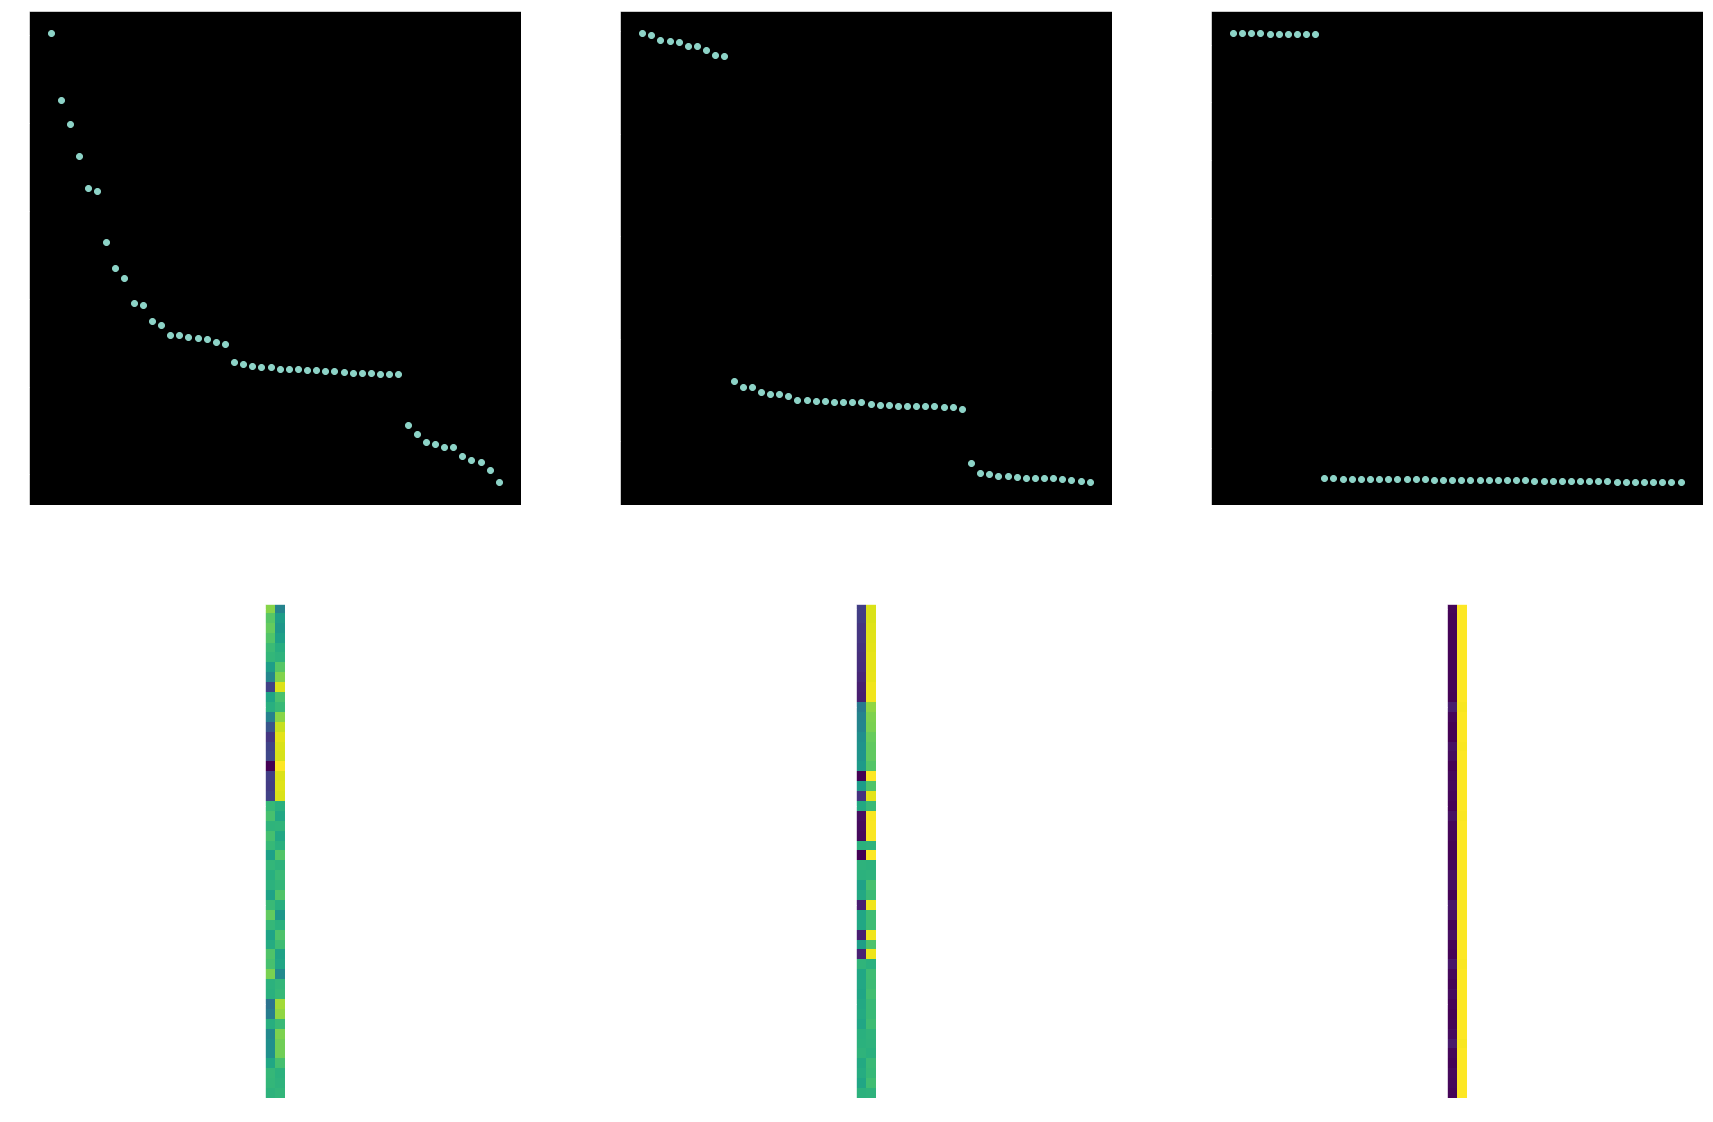

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

for i,hid_dim in enumerate(hid_dims):
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    eigenval, eigenvec = compute_hessian_eigenthings(model, ds, loss_fn, Neigen)
    eigenval = torch.from_numpy(eigenval.copy()).float()
    eigenvec = torch.from_numpy(eigenvec.copy()).float()
    plot_leading_eigen(eigenval, eigenvec, model, Neigen, ax=ax[:,i])

In [10]:
nlayer = 2
hid_dims = [10, 100, 1000]
eigenvals, eigenvecs = {},{}

for hid_dim in hid_dims:
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, "linear").cuda(device)
    for x in model.parameters():
        x.requires_grad_(False)
        x.normal_(0, 1/np.sqrt(x.shape[1]))
        x.requires_grad_(True)
        
    ds = gen_rnd_ds(inp_dim, 1, 1, 
                   out_dim, nsamp, device)
    loss_fn = SquaredClassification(out_dim)
    eigenval, eigenvec = compute_hessian_eigenthings(model, ds,
                                                      loss_fn, Neigen)
    
    eigenvals[hid_dim]=eigenval
    eigenvecs[hid_dim]=eigenvec

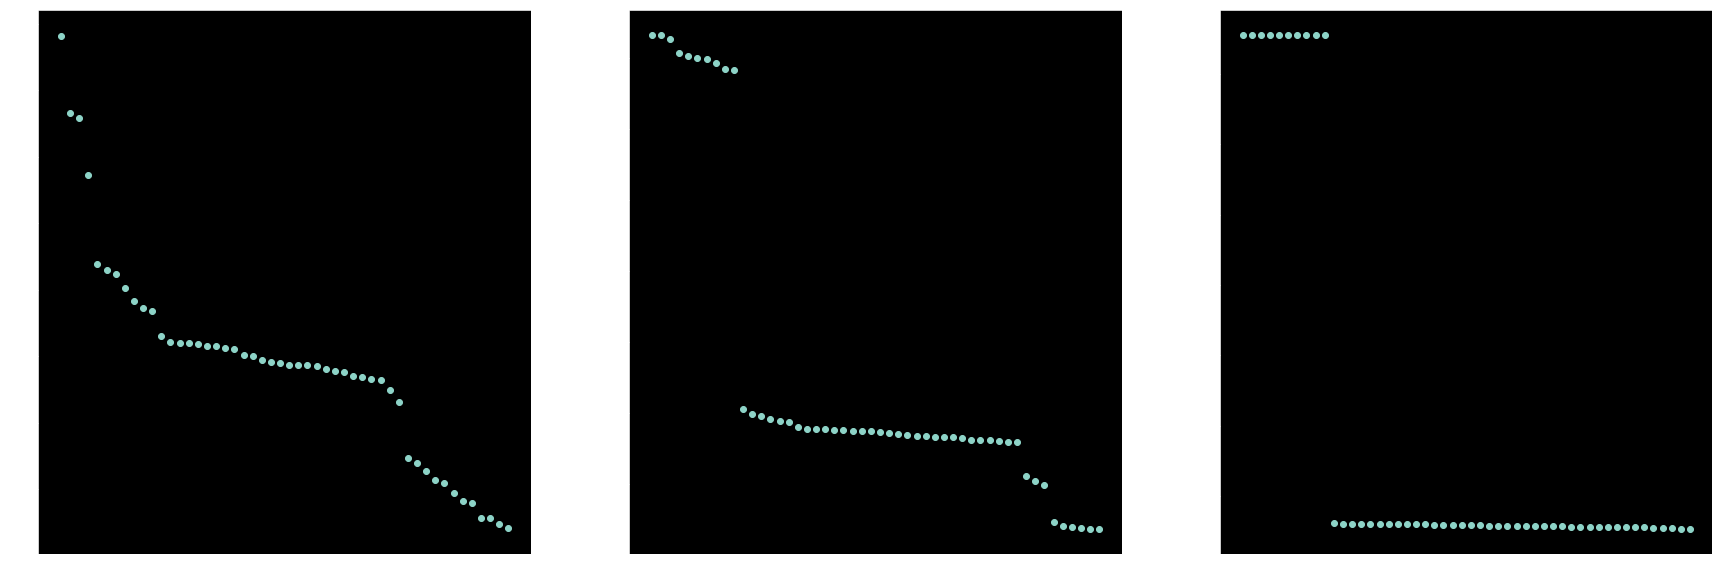

In [11]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].scatter(torch.arange(Neigen), eigenvals[hid_dim])

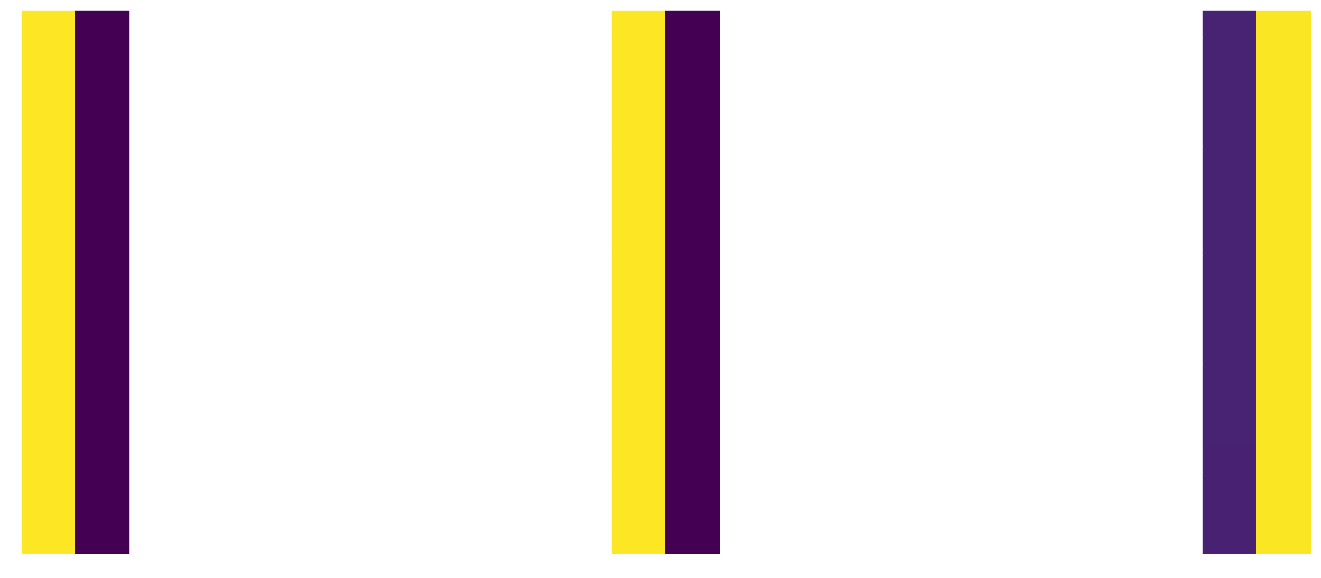

In [12]:
idx = infer_layer_idx(model.parameters())

dist = {}
for hid_dim in hid_dims:
    eigenvec = eigenvecs[hid_dim]
    dist[hid_dim] = np.concatenate([np.linalg.norm(eigenvec[:out_dim, idx[i]:idx[i+1]], axis=1)[None,:] for i in range(nlayer)])
    
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].imshow(dist[hid_dim].T, vmin=0, vmax=1)

In [14]:
#dist

In [19]:
nlayer = 2
hid_dims = [10, 100, 1000]
eigenvals, eigenvecs = {},{}
inp_dim = 100

for hid_dim in hid_dims:
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, "linear").cuda(device)
    for x in model.parameters():
        x.requires_grad_(False)
        x.normal_(0, 1/x.shape[0])
        x.requires_grad_(True)
    ds = gen_rnd_ds(inp_dim, 1, 1, 
                   out_dim, nsamp, device)
    loss_fn = SquaredClassification(out_dim)
    eigenval, eigenvec = compute_hessian_eigenthings(model, ds,
                                                      loss_fn, Neigen)
    
    eigenvals[hid_dim]=eigenval
    eigenvecs[hid_dim]=eigenvec

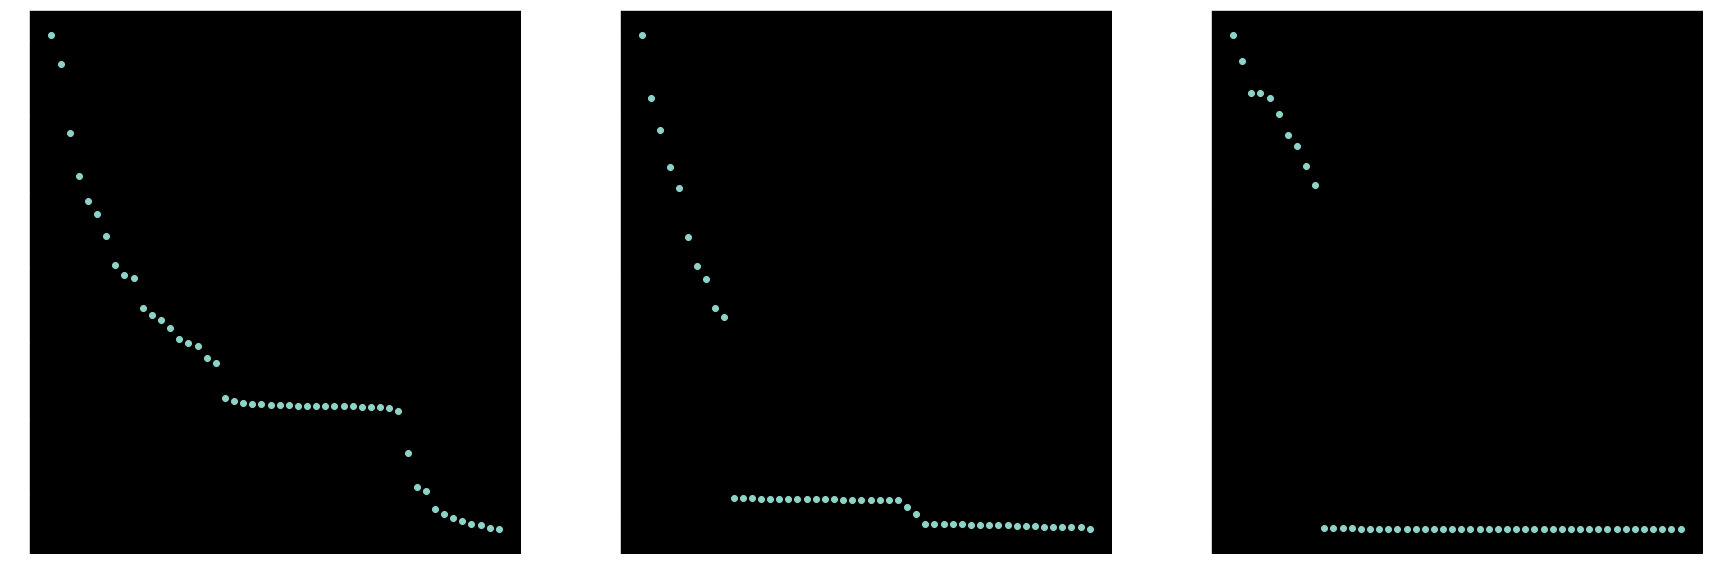

In [20]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].scatter(torch.arange(Neigen), eigenvals[hid_dim])

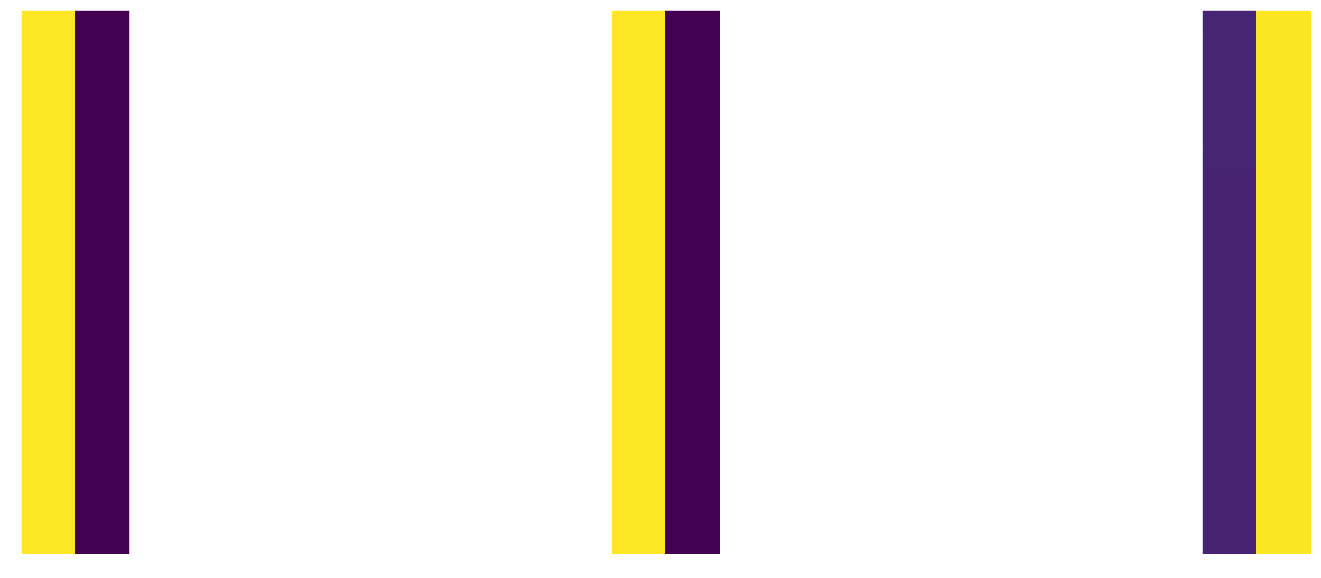

In [9]:
idx = infer_layer_idx(model.parameters())

dist = {}
for hid_dim in hid_dims:
    eigenvec = eigenvecs[hid_dim]
    dist[hid_dim] = np.concatenate([np.linalg.norm(eigenvec[:out_dim, idx[i]:idx[i+1]], axis=1)[None,:] for i in range(nlayer)])
    
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].imshow(dist[hid_dim].T, vmin=0, vmax=1)

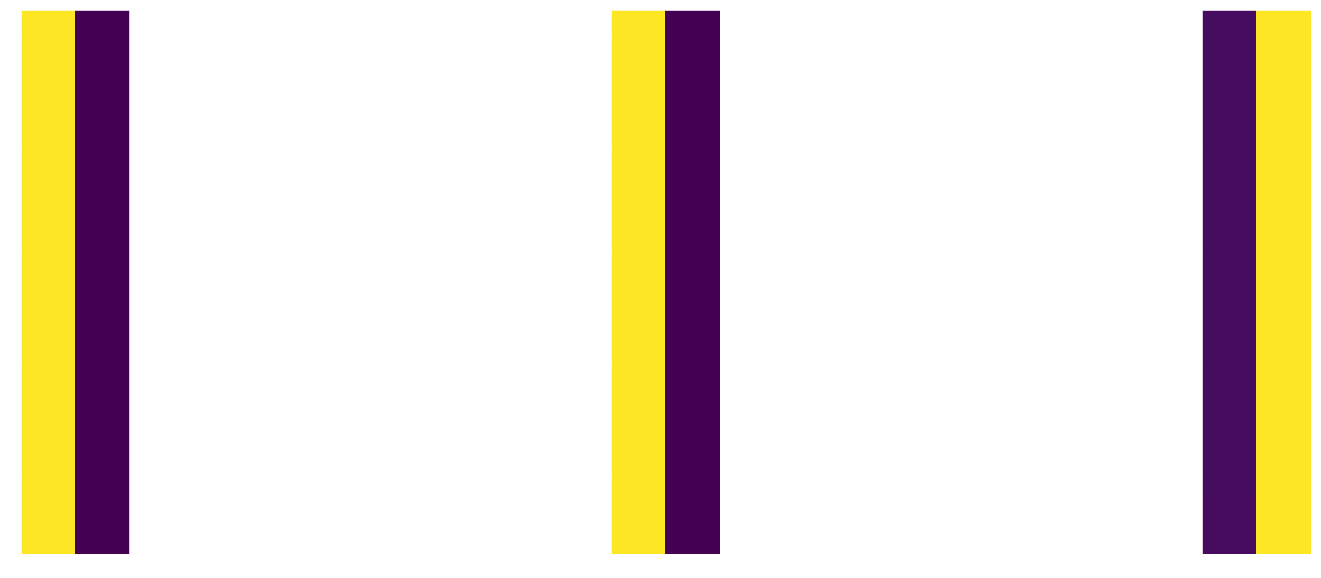

In [6]:
idx = infer_layer_idx(model.parameters())

dist = {}
for hid_dim in hid_dims:
    eigenvec = eigenvecs[hid_dim]
    dist[hid_dim] = np.concatenate([np.linalg.norm(eigenvec[:out_dim, idx[i]:idx[i+1]], axis=1)[None,:] for i in range(nlayer)])
    
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].imshow(dist[hid_dim].T, vmin=0, vmax=1)

### 3 layers

In [7]:
nlayer = 3
hid_dims = [10, 100, 1000]
eigenvals, eigenvecs = {},{}

for hid_dim in hid_dims:
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                   out_dim, nsamp, device)
    loss_fn = SquaredClassification(out_dim)
    eigenval, eigenvec = compute_hessian_eigenthings(model, ds,
                                                      loss_fn, Neigen)
    
    eigenvals[hid_dim]=eigenval
    eigenvecs[hid_dim]=eigenvec

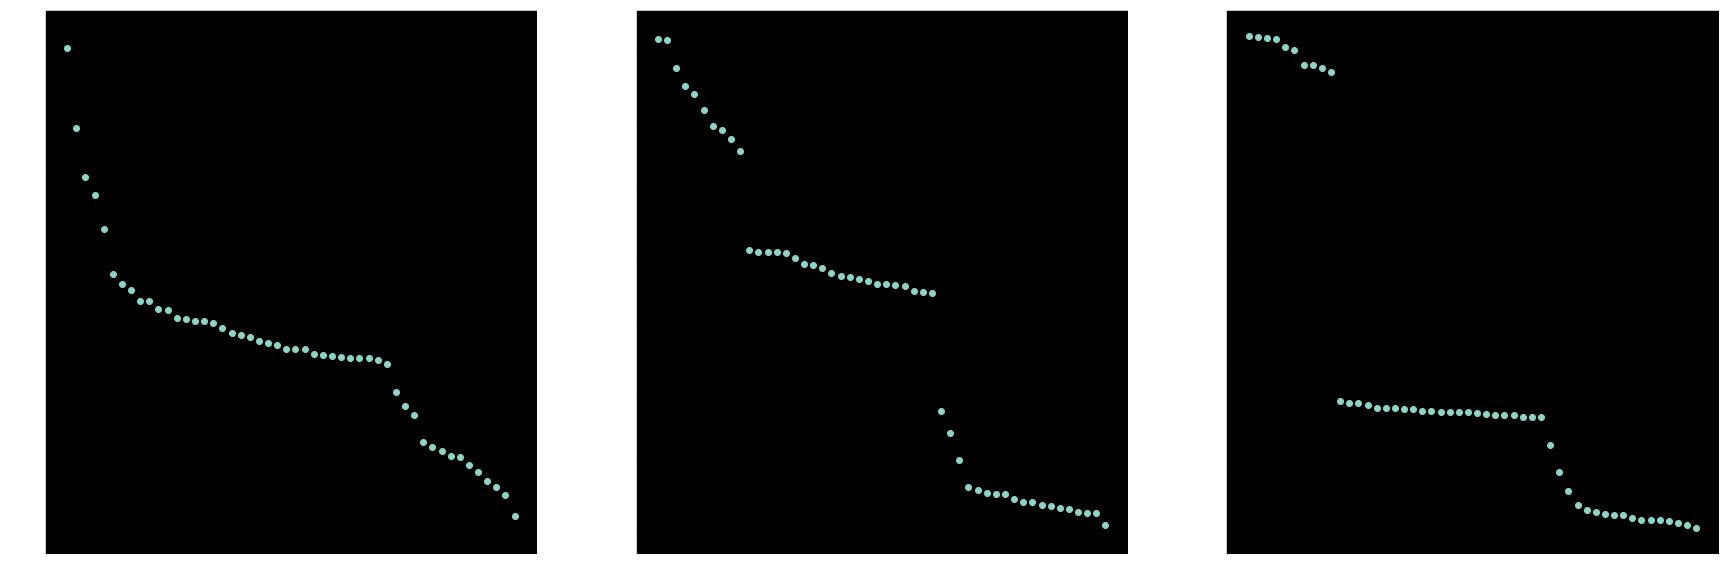

In [8]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].scatter(torch.arange(Neigen), eigenvals[hid_dim])

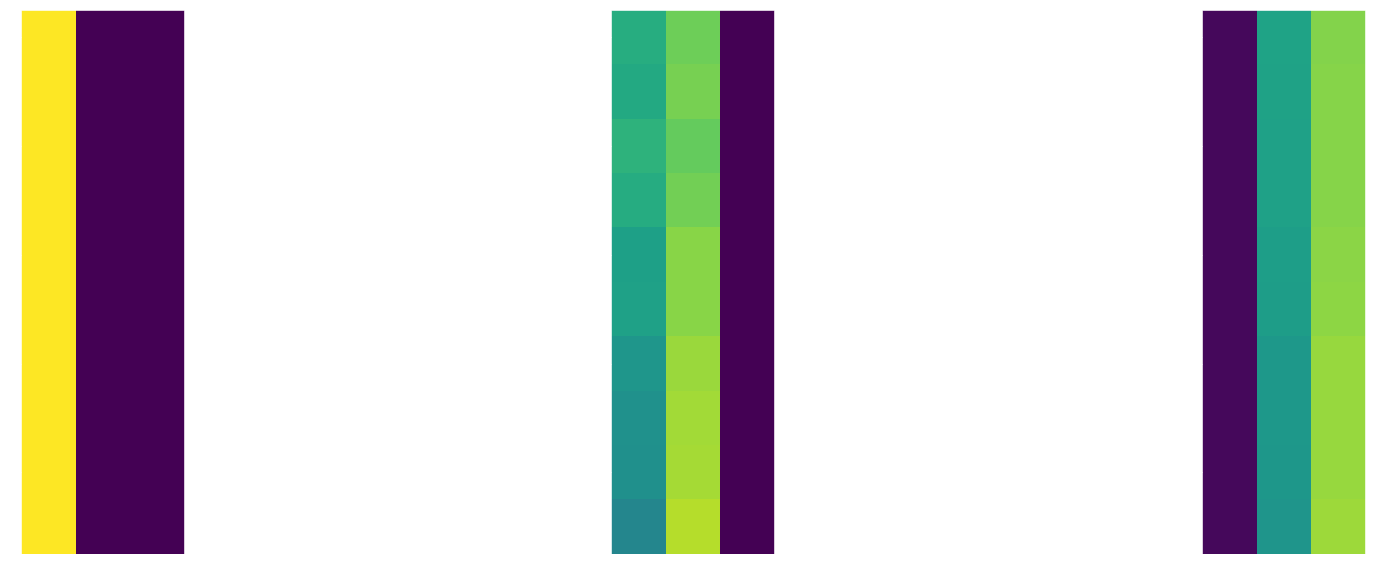

In [9]:
idx = infer_layer_idx(model.parameters())

dist = {}
for hid_dim in hid_dims:
    eigenvec = eigenvecs[hid_dim]
    dist[hid_dim] = np.concatenate([np.linalg.norm(eigenvec[:out_dim, idx[i]:idx[i+1]], axis=1)[None,:] for i in range(nlayer)])
    
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].imshow(dist[hid_dim].T, vmin=0, vmax=1)

### 4 layers

In [10]:
nlayer = 4
hid_dims = [10, 100, 1000]
eigenvals, eigenvecs = {},{}

for hid_dim in hid_dims:
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                   out_dim, nsamp, device)
    loss_fn = SquaredClassification(out_dim)
    eigenval, eigenvec = compute_hessian_eigenthings(model, ds,
                                                      loss_fn, Neigen)
    
    eigenvals[hid_dim]=eigenval
    eigenvecs[hid_dim]=eigenvec

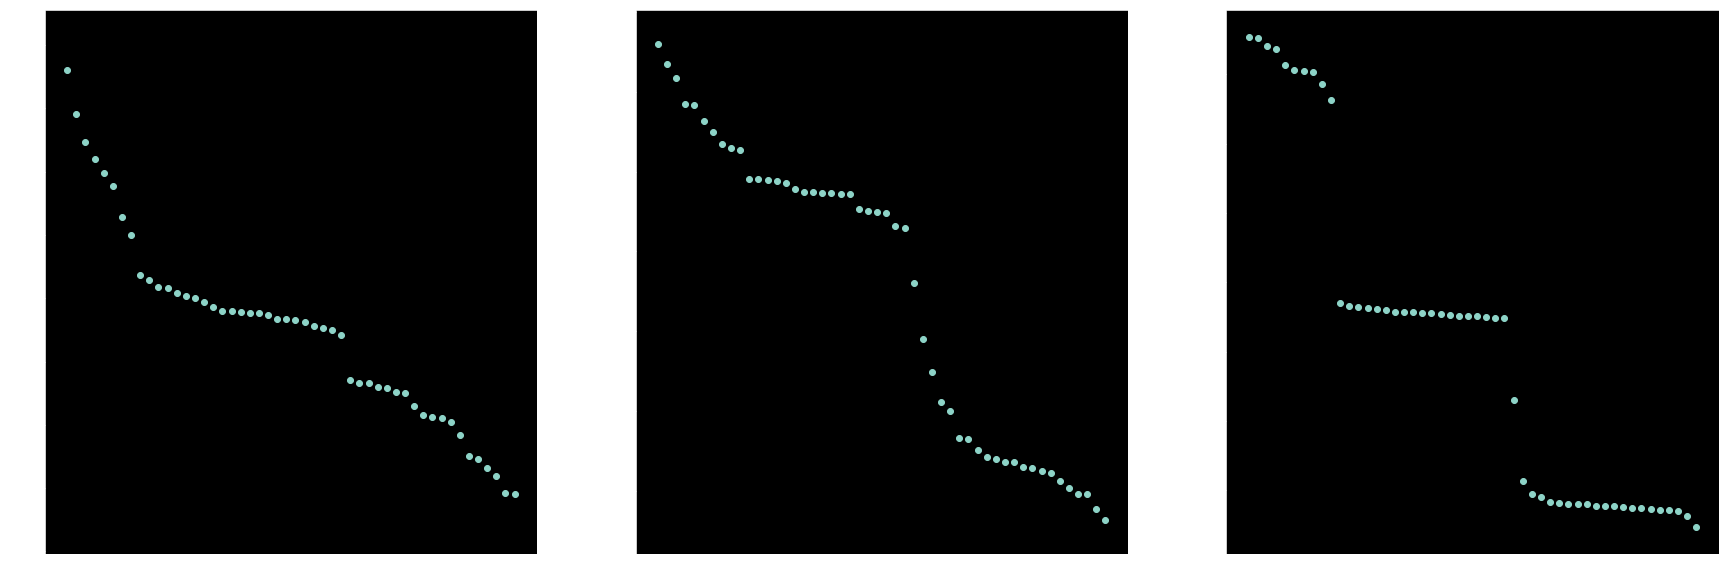

In [11]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].scatter(torch.arange(Neigen), eigenvals[hid_dim])

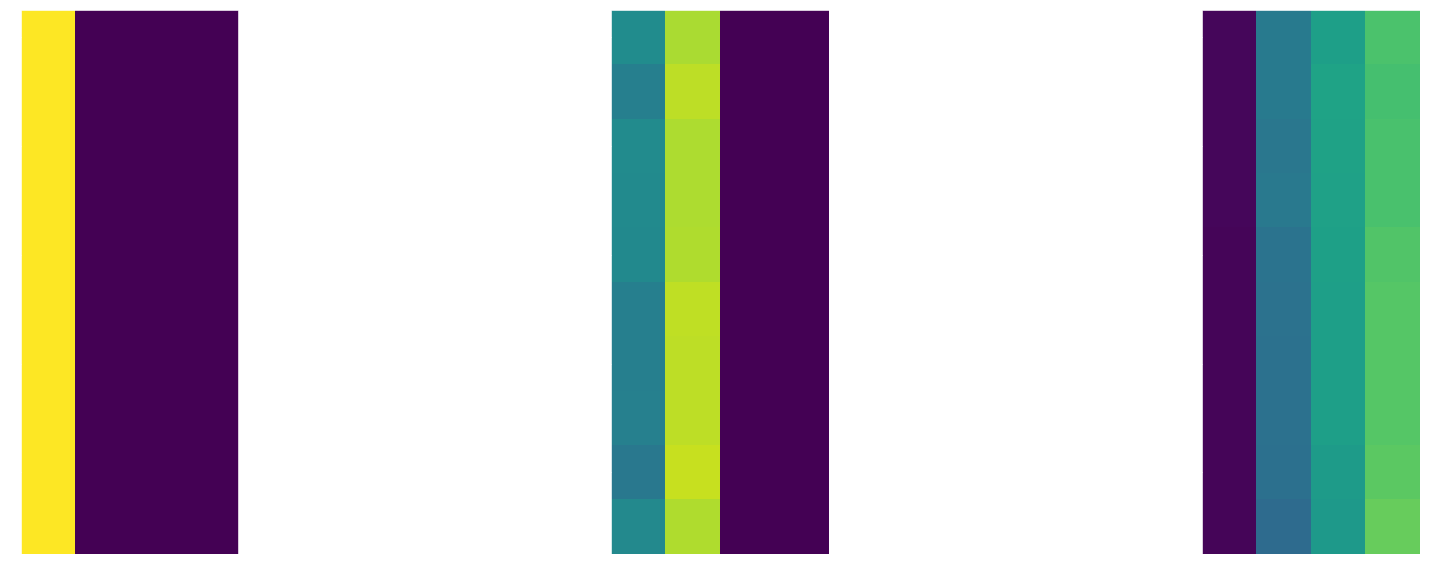

In [12]:
idx = infer_layer_idx(model.parameters())

dist = {}
for hid_dim in hid_dims:
    eigenvec = eigenvecs[hid_dim]
    dist[hid_dim] = np.concatenate([np.linalg.norm(eigenvec[:out_dim, idx[i]:idx[i+1]], axis=1)[None,:] for i in range(nlayer)])
    
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i,hid_dim in enumerate(hid_dims):
    ax[i].imshow(dist[hid_dim].T, vmin=0, vmax=1)

### old

 47%|████▋     | 23/49 [00:00<00:00, 228.85it/s]

[Complete LANCZOS Algorithm running]


100%|██████████| 49/49 [00:00<00:00, 159.68it/s]


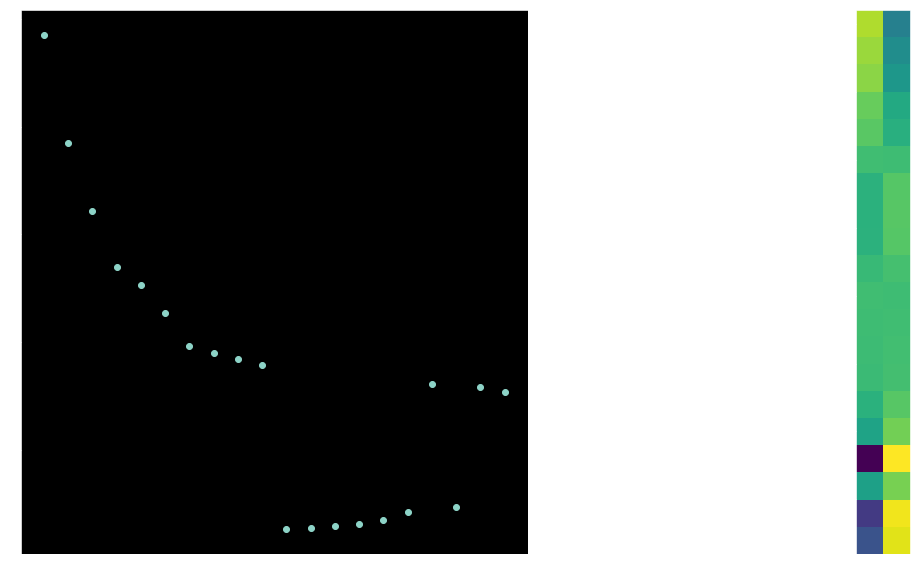

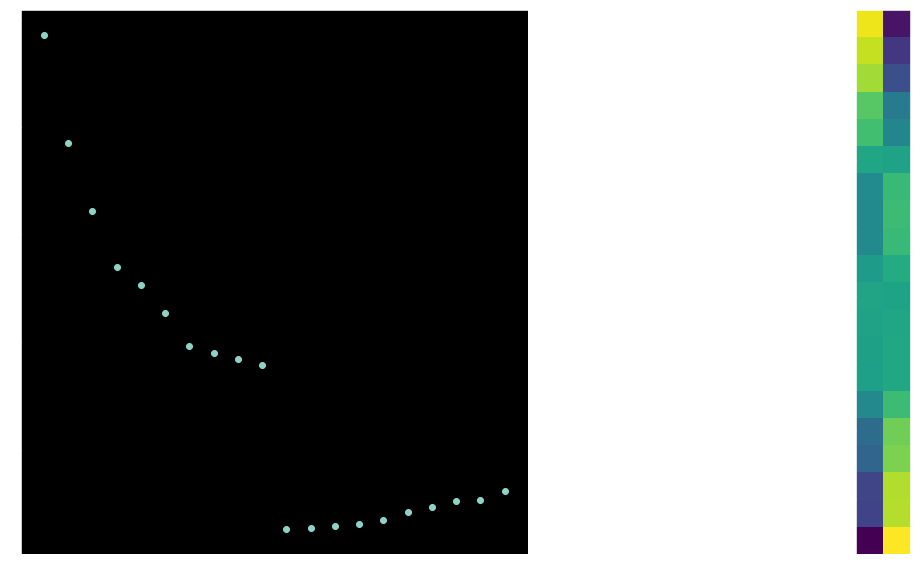

In [5]:
hid_dim  = 10

model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
               out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)

eigenval, eigenvec = analytic_hessian_eigen(model, ds, loss_fn)
plot_leading_eigen(eigenval, eigenvec, model)

eigenval, eigenvec = batch_hessian_eigen(model, ds, loss_fn, Neigen)
plot_leading_eigen(eigenval, eigenvec, model)